### Análise 2 - A teoria do achismo

A análise abaixo consistem na aplicação de técnicas baseadas no achismo não-ortodoxas a fim de criar um robô de trade. 

In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

import pandas as pd
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


In [2]:
names = ['sell', 'buy', 'last', 'vol', 'high', 'low', 'date']

data = pd.read_csv('btc.csv', names=names, skiprows=1)

In [3]:
data.head()

,sell,buy,last,vol,high,low,date
0,23000.0,22900.0,23000.0,788.669923,23990.0,20600.0,1509541173
1,23000.0,22900.0,23000.0,788.467873,23990.0,20600.0,1509541173
2,23000.0,22900.0,23000.0,788.467873,23990.0,20600.0,1509541173
3,23000.0,22900.0,23000.0,788.679923,23990.0,20600.0,1509541173
4,23000.0,22900.0,23000.0,788.482139,23990.0,20600.0,1509541189


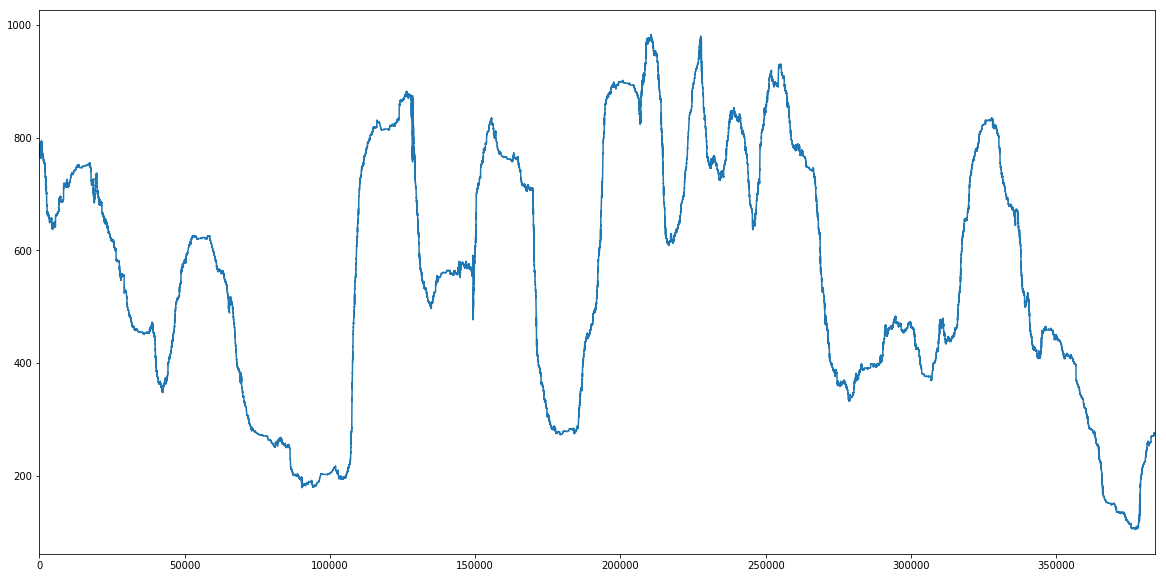

In [4]:
data['vol'].plot()

Acima é a representação do volume no período observado

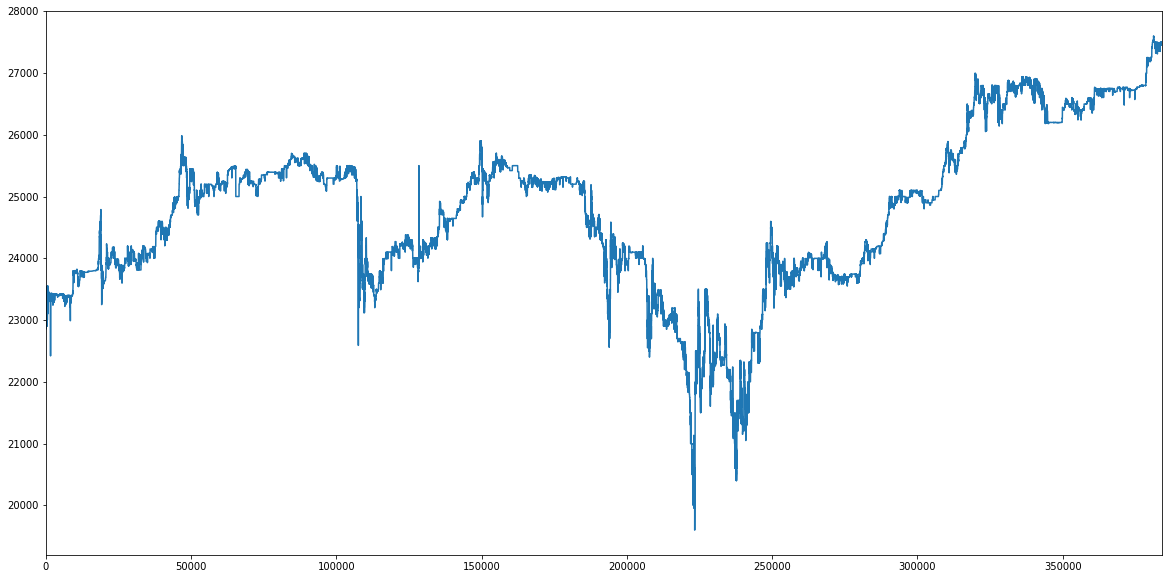

In [5]:
data['sell'].plot()

### Achismo 1
O modus operandi básico no mercado de ações é comprar na baixa e vender na alta. Para que essa regra seja satisfeita, algumas métricas de variação teriam que ser estabelecidas para que o **algoritmo soubesse quando existem períodos de estabilidade, aumento e queda nas ações.**

A regras estabelecida foi bem simples: os valores referente a cotação dos valores de vendas e compras serão calculados usando a seguinte fórmula:

``` math
 V = P(atual) - P(antigo)
 
 P = Preço
 V = Valor
```

Se o falor **atual for maior do que o antigo**, o valor será acima de zero, ou seja, haverá uma valorização no preço.

Se o valor **atual for menor do que o antigo**, o valor será abaixo de zero, consequentemente houve uma desvalorização. 

Quando o resultado é zero, houve um estabilidade no preço. 


In [6]:
array = data['sell'].as_matrix();

variation_sell = []
for index in range(0, len(array)):
    if index == len(array) - 1: 
        break
    variation_sell.append( array[index + 1] - array[index])

array = data['buy'].as_matrix();

variation_buy = []
for index in range(0, len(array)):
    if index == len(array) - 1: 
        break
    variation_buy.append( array[index + 1] - array[index])

In [7]:
data['variation_sell'] = pd.DataFrame(data=variation_sell)
data['variation_buy'] = pd.DataFrame(data=variation_buy)

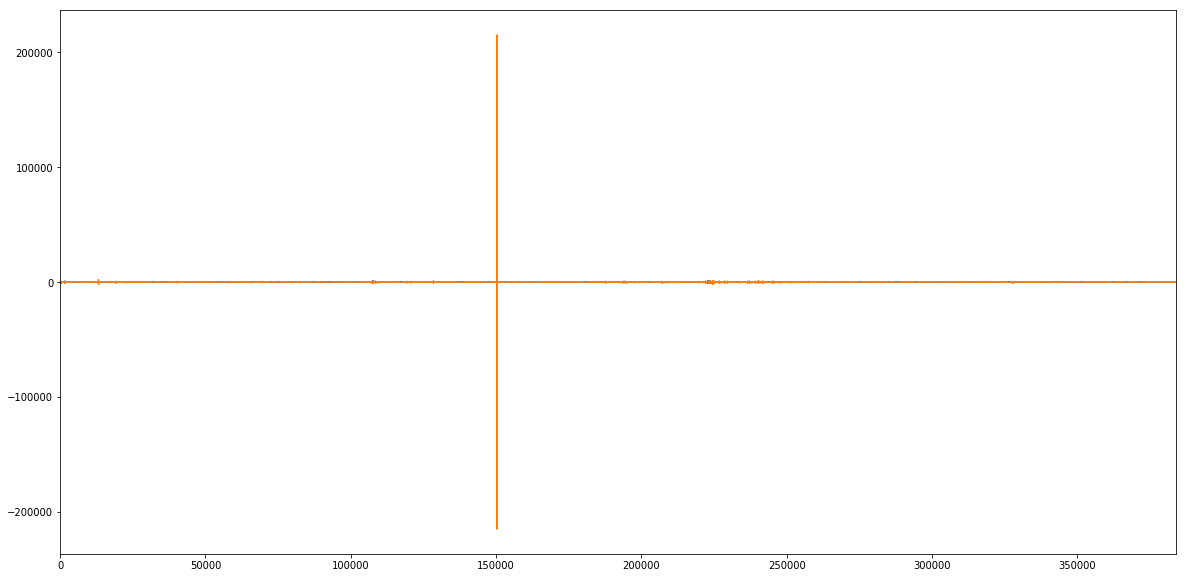

In [8]:
data['variation_sell'].plot()
data['variation_buy'].plot()

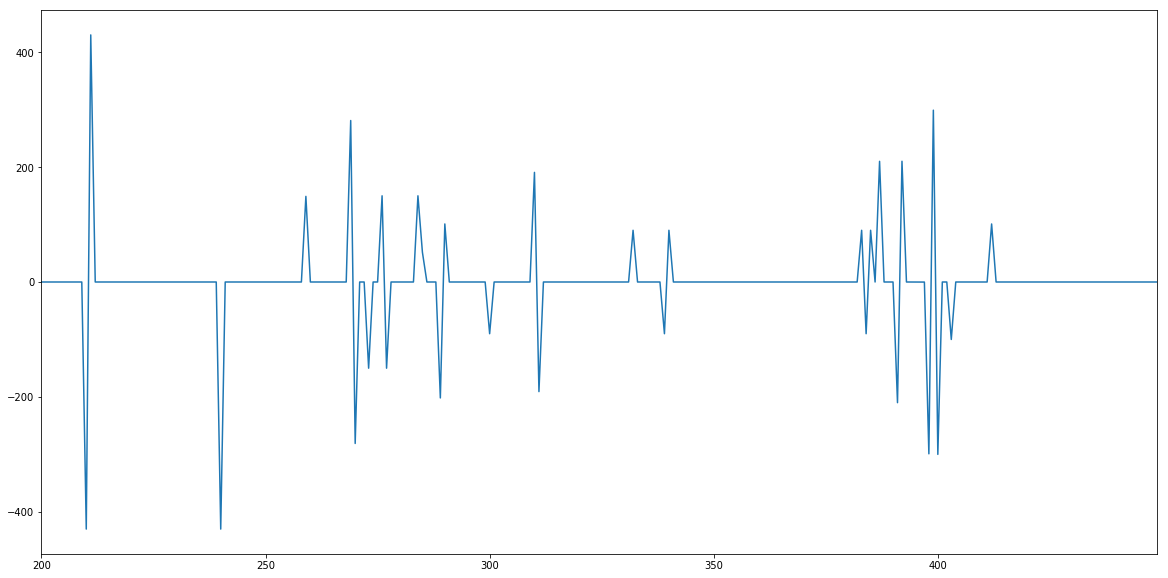

In [9]:
data['variation_sell'][200:450].plot()

Nota-se que em relação ao gráfico abaixo, o gráfico acima tem um comportamento "binário" de como as coisas estão acontecendo na realidade. 

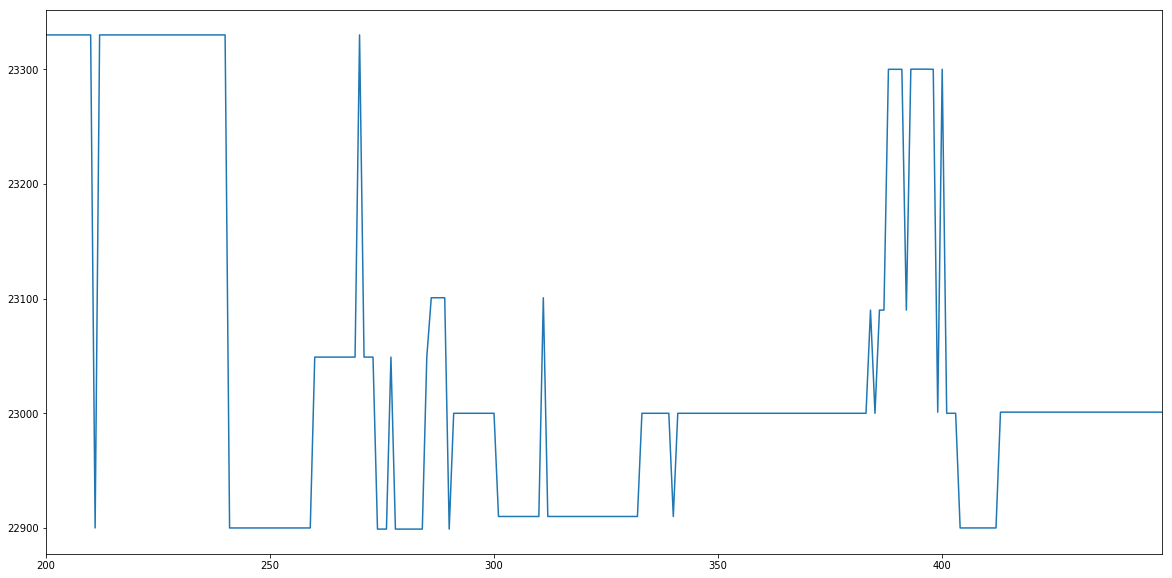

In [10]:
data['sell'][200:450].plot()

### Estabelecendo parâmetros que favoreçam a compra e venda
Ainda bebendo da fonte de "compre na baixa e venda na alta", algumas suposições podem ser feitas sobre os valores das variações.

No **caso da compra**, se a variação for menor do que zero, tal comportamento poeria indicar um momento favorável para compra.

No **caso da venda**, se a variação for maior do que zero, tal comportamento favorece a venda para obtenção de lucro. 

In [11]:
data['sell?'] = data['variation_sell'] > 0.0
data['buy?'] = data['variation_buy'] < 0.0

In [12]:
data.head(10)

,sell,buy,last,vol,high,low,date,variation_sell,variation_buy,sell?,buy?
0,23000.0,22900.0,23000.0,788.669923,23990.0,20600.0,1509541173,0.0,0.0,False,False
1,23000.0,22900.0,23000.0,788.467873,23990.0,20600.0,1509541173,0.0,0.0,False,False
2,23000.0,22900.0,23000.0,788.467873,23990.0,20600.0,1509541173,0.0,0.0,False,False
3,23000.0,22900.0,23000.0,788.679923,23990.0,20600.0,1509541173,0.0,0.0,False,False
4,23000.0,22900.0,23000.0,788.482139,23990.0,20600.0,1509541189,0.0,0.0,False,False
5,23000.0,22900.0,22900.0,788.477748,23990.0,20600.0,1509541195,0.0,0.0,False,False
6,23000.0,22900.0,23000.0,788.485538,23990.0,20600.0,1509541196,0.0,0.0,False,False
7,23000.0,22900.0,23000.0,788.485538,23990.0,20600.0,1509541196,0.0,0.0,False,False
8,23000.0,22900.0,23000.0,788.485538,23990.0,20600.0,1509541196,0.0,0.0,False,False
9,23000.0,22900.0,23000.0,788.485538,23990.0,20600.0,1509541196,0.0,0.0,False,False


### Stop Loss and Start Gain

O método da variação nos possibilita enxergar de maneira autônoma momentos que são favoráveis para compra e venda. O método da variação guarda contexto de apenas dois valores: o imediatamente anterior e o atual. Por esse motivo, trades apenas baseados nessa análise poderia cuminar num total fracasso.

#### Quando comprar?

Vamos supor um caso hipotético em que a variação nos diz que as últimas 5 cotações são favoráveis para compra, a série seria:
* 100
* 99
* 98
* 97
* 96

Comprar na última cotação não seria o mais sensato. Ou as ações se **estabilizariam por muito tempo** ou **cairiam ainda mais**. Seria interessante se o algoritmo armazenasse a referência do primeiro valor que aprensenta favorecimento de compra. O algoritmos tomaria a decisão de compra assim que o preço começasse a subir novamente. Por exemplo: 

* 100
* 99
* 98
* 97
* __96__
* 96
* 96
* 96
* __97__

Entre o valor 96 e 97 houve um período de estabilidade e um de valorização. Assim que esse cenário ocorrer, o algoritmo iria calcular se valeria a pena comprar essa ação, exemplo:

``` math
V1 = 100
V2 = 97

Profit = V1 - V2

Neste caso: 
Profit = 3

```
Nesse casou house 3 unidades de lucro. Portanto, poderia valer a pena.

#### Quando vender?
A venda poderia ser o processo inverso do explanado acima. A variação iria disparar uma flag de favorável a venda e o código iria esperar até que o valor comece a depreciar novamente. 

### Outras métricas

[link](https://www.tororadar.com.br/investimento/analise-tecnica/analise-tecnica-de-acoes)
[link](https://www.metatrader5.com/pt/terminal/help/indicators/trend_indicators/ma)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 200, 100

In [14]:
short_window = 300
long_window = 500

In [15]:
short_variation = data['sell'].rolling(window=short_window, min_periods=1, center=False).mean()
long_variation = data['sell'].rolling(window=long_window, min_periods=1, center=False).mean()


In [16]:
signals = pd.DataFrame(index=data.index)
signals['signal'] = 0.0

In [17]:
signals['signal'][short_window:] = np.where( 
    short_variation[short_window:] > long_variation[short_window:]
    , 1.0, 0.0)

In [18]:
positions = signals['signal'].diff()

In [19]:
# fig = plt.figure()
# fig.patch.set_facecolor('white')

# ax1 = fig.add_subplot(211)

# data['sell'].plot(ax=ax1, color='r')

# short_variation.plot(ax=ax1)
# long_variation.plot(ax=ax1)

# ax1.plot(
#     signals['signal'].ix[ positions == 1.0].index,
#     short_variation[positions == 1.0], '^', markersize=10, color='m')

# ax1.plot(
#     signals['signal'].ix[ positions == -1.0].index,
#     short_variation[positions == -1.0], 'v', markersize=10, color='k')

# fig.show()

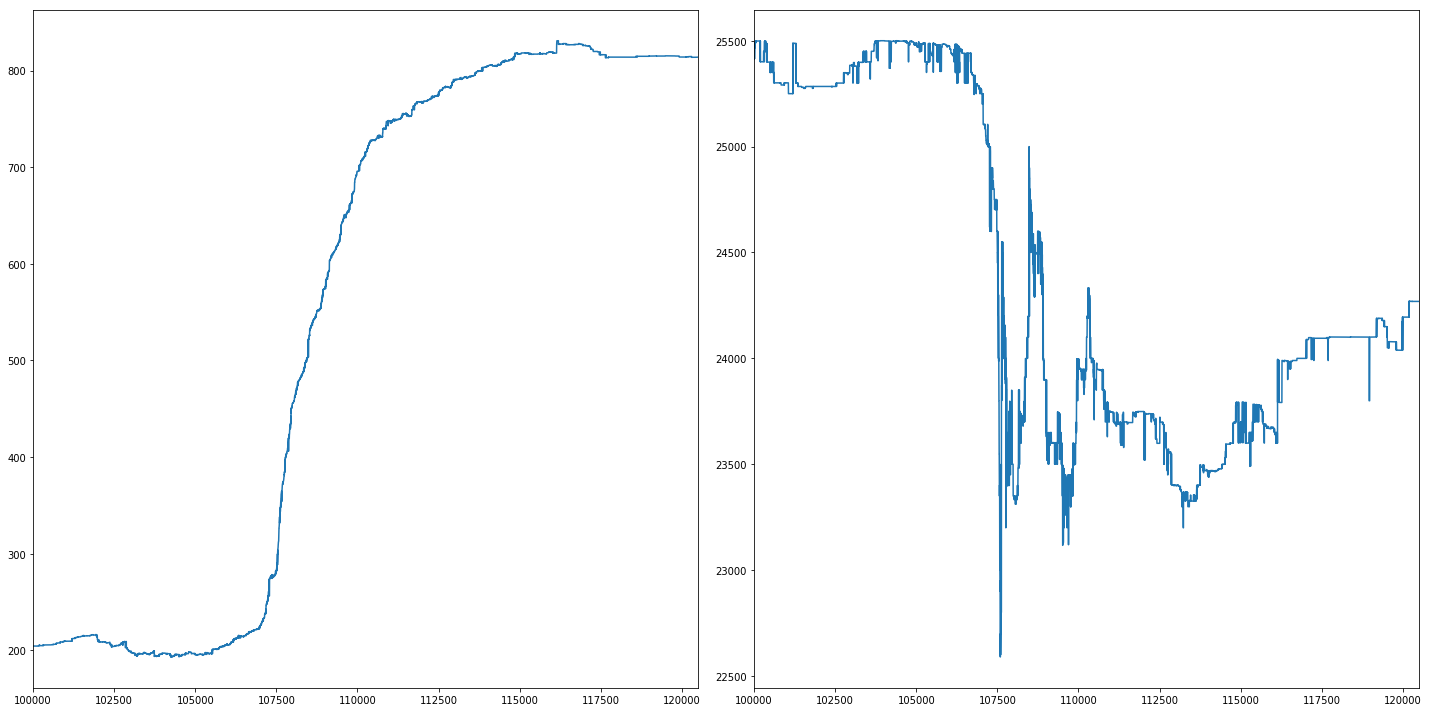

In [20]:
start = 100000
end = 120500
rcParams['figure.figsize'] = 20, 10
fig, axs = plt.subplots(1,2)

data['vol'][start:end].plot(ax=axs[0])
data['sell'][start:end].plot(ax=axs[1])
plt.tight_layout()

In [21]:
buy_signal = signals['signal'][ positions == 1.0].index
sell_signal = signals['signal'][ positions == -1.0].index

In [22]:
minimum_profit_accetable = 0.002

In [23]:
len(buy_signal), len(sell_signal)

(459, 459)

In [24]:
result = [None] * len(sell_signal)
indexes = [None] * len(sell_signal)

for index in range(len(sell_signal)):
    starts = buy_signal[index]
    ends = sell_signal[index]

    result[index] = data['sell'].iloc[starts:ends].as_matrix()
    indexes[index] = (starts, ends)

In [25]:
def get_valorization(first_value, last_value): 
    temp = ( first_value - last_value ) / first_value
    
    return 0.0 if temp < 0 else temp

In [26]:
training_set = []

for index in range(len(sell_signal)): 
    operation = result[index]
    
    first_value = operation[0]
    last_value = operation[-1]
    
    valorization = get_valorization(first_value, last_value)
    
    last_index = indexes[index][-1]
    
    if len(data['variation_sell'][:last_index]) < short_window: 
        continue
        
    event = data['variation_sell'][last_index - short_window: last_index]
    
    training_set.append([event.as_matrix(), indexes[index][0], indexes[index][1], valorization])

In [27]:
training_set = pd.DataFrame(data=training_set, columns=['data', 'start', 'ends', 'valorization'])

In [28]:
training_set['valorization'].describe()

count    459.000000
mean       0.001436
std        0.002767
min        0.000000
25%        0.000000
50%        0.000023
75%        0.001949
max        0.021330
Name: valorization, dtype: float64

In [29]:
training_set['acceptable'] = training_set['valorization'] >= minimum_profit_accetable

In [30]:
training_set[ training_set['acceptable'] == True ].head()

,data,start,ends,valorization,acceptable
9,"[0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, -8.0, 0.0...",2832,2909,0.005081,True
13,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5482,5837,0.002989,True
15,"[0.0, -0.010000000002, 0.0, -0.0099999999984, ...",6796,7060,0.004820,True
18,"[1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.9...",9996,10873,0.002101,True
20,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",12499,12530,0.003026,True


In [31]:
def normalize(x): 
    if x == 0.0: 
        return 0
    if x > 0.0: 
        return 1
    if x < 0.0: 
        return -1

training_set['data'] = training_set['data'].apply(lambda x: np.asarray([ normalize(value) for value in x ]))

In [32]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

length = len(training_set['data'])

X = [None] * length
y = training_set['acceptable']

for index in range(length): 
    X[index] = training_set['data'].iloc[index]
    
clf.fit(X, training_set['acceptable'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
clf.score(X, y)

0.97603485838779958

In [34]:
clf.predict([X[1]])

array([False], dtype=bool)

In [35]:
zip(clf.predict_proba([X[1]])[0], clf.classes_)

[(0.99003270380834607, False), (0.0099672961916539588, True)]